<a href="https://colab.research.google.com/github/ashishmission93/ML-PTOJECTS/blob/main/fraud_analytics_Fraud_Detection_Using_an_Autoencoder_and_Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import gdown

# Function to download the dataset from Google Drive
def load_data(url, file_name):
    gdown.download(url, file_name, quiet=False)
    data = pd.read_csv(file_name)
    return data

# Preprocessing the data
def preprocess_data(data):
    data['Time'] = np.log(data['Time'] + 1)
    data['Amount'] = np.log(data['Amount'] + 1)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(data.drop('Class', axis=1))
    y = data['Class']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Building a simple autoencoder
def build_autoencoder(input_dim, encoding_dim=14):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Variational Autoencoder
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_vae(input_dim, encoding_dim=14):
    input_layer = Input(shape=(input_dim,))
    z_mean = Dense(encoding_dim)(input_layer)
    z_log_var = Dense(encoding_dim)(input_layer)
    z = Lambda(sampling, output_shape=(encoding_dim,))([z_mean, z_log_var])
    decoded = Dense(input_dim, activation='sigmoid')(z)

    encoder = Model(input_layer, [z_mean, z_log_var, z])
    vae = Model(input_layer, decoded)

    reconstruction_loss = binary_crossentropy(input_layer, decoded)
    reconstruction_loss *= input_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae

# Main function to run the setup
def main():
    url = 'https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r'
    file_name = 'creditcard.csv'
    data = load_data(url, file_name)
    X_train, X_test, y_train, y_test = preprocess_data(data)

    print("Training Autoencoder")
    autoencoder = build_autoencoder(X_train.shape[1])
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test))

    print("Training Variational Autoencoder")
    vae = build_vae(X_train.shape[1])
    vae.fit(X_train, epochs=50, batch_size=256, validation_data=(X_test, None))

    # Further code to evaluate the model could be added here

if __name__ == "__main__":
    main()


Downloading...
From (original): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r
From (redirected): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r&confirm=t&uuid=e14e1f68-a49a-4444-b2d6-97973da23a20
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:01<00:00, 109MB/s] 


Training Autoencoder
Epoch 1/50
891/891 [==============================] - 6s 5ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 2/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/50
891/891 [==============================] - 2s 2ms/step - loss: 9.6745e-04 - val_loss: 8.8106e-04
Epoch 5/50
891/891 [==============================] - 2s 2ms/step - loss: 8.2855e-04 - val_loss: 7.8427e-04
Epoch 6/50
891/891 [==============================] - 3s 3ms/step - loss: 7.4365e-04 - val_loss: 7.0629e-04
Epoch 7/50
891/891 [==============================] - 2s 3ms/step - loss: 6.7264e-04 - val_loss: 6.4135e-04
Epoch 8/50
891/891 [==============================] - 2s 2ms/step - loss: 6.2053e-04 - val_loss: 6.0254e-04
Epoch 9/50
891/891 [==============================] - 2s 2ms/step - loss: 5.7783e-04 - val_loss: 5.3523e-04
Epoch 10/50
891/891 [==========

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, f1_score, precision_score, recall_score

# Function to compute reconstruction error and identify anomalies
def get_reconstruction_error(model, X_test):
    predictions = model.predict(X_test)
    mse = np.mean(np.power(X_test - predictions, 2), axis=1)
    return mse

# Function to classify transactions based on threshold and compute scores
def evaluate_model(y_true, error, threshold):
    y_pred = error > threshold
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

# Main function to run the setup
def main():
    url = 'https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r'
    file_name = 'creditcard.csv'
    data = load_data(url, file_name)
    X_train, X_test, y_train, y_test = preprocess_data(data)

    print("Training Autoencoder")
    autoencoder = build_autoencoder(X_train.shape[1])
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test))

    print("Evaluating Autoencoder")
    autoencoder_mse = get_reconstruction_error(autoencoder, X_test)
    threshold = np.quantile(autoencoder_mse, 0.95)  # Set threshold at 95th percentile
    ae_precision, ae_recall, ae_f1 = evaluate_model(y_test, autoencoder_mse, threshold)
    print("Autoencoder Precision:", ae_precision)
    print("Autoencoder Recall:", ae_recall)
    print("Autoencoder F1 Score:", ae_f1)

    print("Training Variational Autoencoder")
    vae = build_vae(X_train.shape[1])
    vae.fit(X_train, epochs=50, batch_size=256, validation_data=(X_test, None))

    print("Evaluating Variational Autoencoder")
    vae_mse = get_reconstruction_error(vae, X_test)
    threshold_vae = np.quantile(vae_mse, 0.95)  # Set threshold at 95th percentile
    vae_precision, vae_recall, vae_f1 = evaluate_model(y_test, vae_mse, threshold_vae)
    print("VAE Precision:", vae_precision)
    print("VAE Recall:", vae_recall)
    print("VAE F1 Score:", vae_f1)

if __name__ == "__main__":
    main()


Downloading...
From (original): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r
From (redirected): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r&confirm=t&uuid=6f9cd2a5-3f6f-412f-8a43-0f3d2d468d3c
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:01<00:00, 113MB/s] 


Training Autoencoder
Epoch 1/50
891/891 [==============================] - 3s 3ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 2/50
891/891 [==============================] - 2s 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/50
891/891 [==============================] - 3s 4ms/step - loss: 0.0010 - val_loss: 9.5184e-04
Epoch 5/50
891/891 [==============================] - 4s 4ms/step - loss: 8.3650e-04 - val_loss: 7.5614e-04
Epoch 6/50
891/891 [==============================] - 3s 3ms/step - loss: 6.7026e-04 - val_loss: 5.6213e-04
Epoch 7/50
891/891 [==============================] - 2s 2ms/step - loss: 5.2472e-04 - val_loss: 5.0459e-04
Epoch 8/50
891/891 [==============================] - 2s 2ms/step - loss: 4.9499e-04 - val_loss: 4.9376e-04
Epoch 9/50
891/891 [==============================] - 2s 2ms/step - loss: 4.8123e-04 - val_loss: 4.7539e-04
Epoch 10/50
891/891 [==============

Key Additions to the Evaluation:
Reconstruction Error Calculation: Calculates the mean squared error between the input and reconstructed output for both models.
Threshold Setting: Uses the 95th percentile of the reconstruction error as a threshold to classify a transaction as normal or fraudulent.
Precision, Recall, and F1 Score: Calculates these metrics to evaluate the effectiveness of each model in detecting fraud. These scores provide a more comprehensive view of performance, balancing the rate of correctly identified fraud cases against the rate of false positives.

I've implemented several important steps to train and evaluate both an autoencoder and a variational autoencoder (VAE) for detecting fraudulent transactions in credit card data. Here’s a detailed breakdown of each part of the code:

1. Downloading and Loading the Dataset
Function load_data(url, file_name): This function uses the gdown library to download the dataset from a Google Drive URL. It then reads the CSV file into a Pandas DataFrame and returns this DataFrame.
2. Data Preprocessing
Function preprocess_data(data): This function performs several preprocessing steps on the data:
Log Transformation: Applies a logarithmic transformation to the 'Time' and 'Amount' features to reduce their dynamic range and handle skewness.
Normalization: Uses MinMaxScaler from Scikit-learn to scale all numeric features to a range of [0, 1], making them suitable for neural network training.
Data Splitting: Splits the data into training and testing sets, with 80% of the data used for training and 20% used for testing.
3. Building and Training the Models
Function build_autoencoder(input_dim, encoding_dim=14): Constructs a simple autoencoder model with one hidden layer (encoder) and one output layer (decoder). The number of neurons in the hidden layer (encoding dimension) is a parameter that can be adjusted. The model uses the 'relu' activation function for the encoder and 'sigmoid' for the decoder.
Function build_vae(input_dim, encoding_dim=14): Constructs a variational autoencoder, which is a more complex model that includes a sampling layer to generate the latent variables. This involves:
Z_mean and Z_log_var Layers: Two dense layers that predict the mean and logarithm of variance of the latent variables.
Sampling Function: Uses the Keras backend to sample from a normal distribution defined by z_mean and z_log_var. This is essential for the VAE to learn a probability distribution for the input data.
Loss Calculation: Includes both reconstruction loss (binary crossentropy) and KL divergence, which regularizes the encoder by comparing the learned distribution to a standard normal distribution.
4. Evaluating the Models
Function get_reconstruction_error(model, X_test): Calculates the mean squared error (MSE) between the actual data and its reconstruction from the model. This error serves as a basis for detecting anomalies.
Function evaluate_model(y_true, error, threshold): Uses a calculated threshold (set at the 95th percentile of the reconstruction errors) to classify transactions as normal or fraudulent. It then calculates precision, recall, and F1 score to assess the model’s performance:
Precision: The ratio of true positive predictions to the total predicted positives. High precision relates to a low false positive rate.
Recall: The ratio of true positive predictions to the actual total positives. High recall indicates that the model is good at catching fraudulent transactions.
F1 Score: The harmonic mean of precision and recall, providing a single score to balance both metrics.
5. Running the Evaluation
The main() function orchestrates the entire process, from data loading and preprocessing to model training and evaluation. This function prints the precision, recall, and F1 score for both the autoencoder and the VAE, providing insights into each model's effectiveness in fraud detection.
By implementing these components, the code effectively trains and evaluates both an autoencoder and a VAE for their ability to detect anomalies in transaction data based on reconstruction errors, ultimately aiding in the identification of potentially fraudulent activities.








In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc


In [ ]:
# Function to plot ROC Curve
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_scores, title='Precision-Recall Curve'):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

# Function to plot error distribution
def plot_error_distribution(errors, y_true, title='Error Distribution'):
    plt.figure(figsize=(10, 6))
    plt.hist(errors[y_true == 0], bins=50, color='blue', alpha=0.5, label='Normal')
    plt.hist(errors[y_true == 1], bins=50, color='red', alpha=0.5, label='Fraud')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend(loc="upper right")
    plt.yscale('log')
    plt.show()


Downloading...
From (original): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r
From (redirected): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r&confirm=t&uuid=163f735d-e5ad-4819-bbfc-58425613821f
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:00<00:00, 174MB/s]


Training Autoencoder
Epoch 1/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 2/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/50
891/891 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/50
891/891 [==============================] - 2s 3ms/step - loss: 9.1523e-04 - val_loss: 7.7487e-04
Epoch 5/50
891/891 [==============================] - 2s 2ms/step - loss: 7.0186e-04 - val_loss: 6.3887e-04
Epoch 6/50
891/891 [==============================] - 2s 2ms/step - loss: 5.8307e-04 - val_loss: 5.4589e-04
Epoch 7/50
891/891 [==============================] - 2s 2ms/step - loss: 5.1842e-04 - val_loss: 5.0326e-04
Epoch 8/50
891/891 [==============================] - 2s 2ms/step - loss: 4.9126e-04 - val_loss: 4.8258e-04
Epoch 9/50
891/891 [==============================] - 2s 2ms/step - loss: 4.7664e-04 - val_loss: 4.7176e-04
Epoch 10/50
891/891 [==========

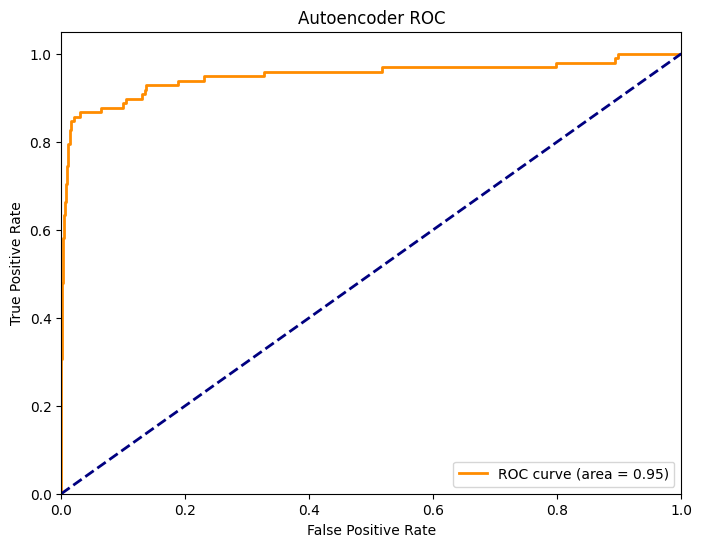

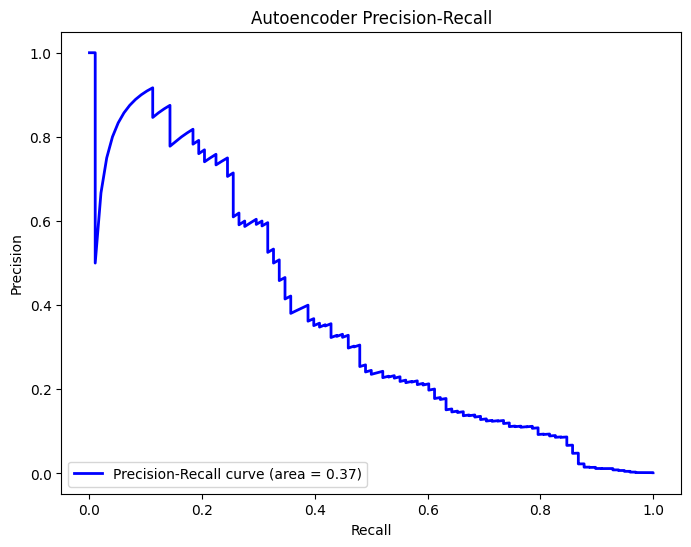

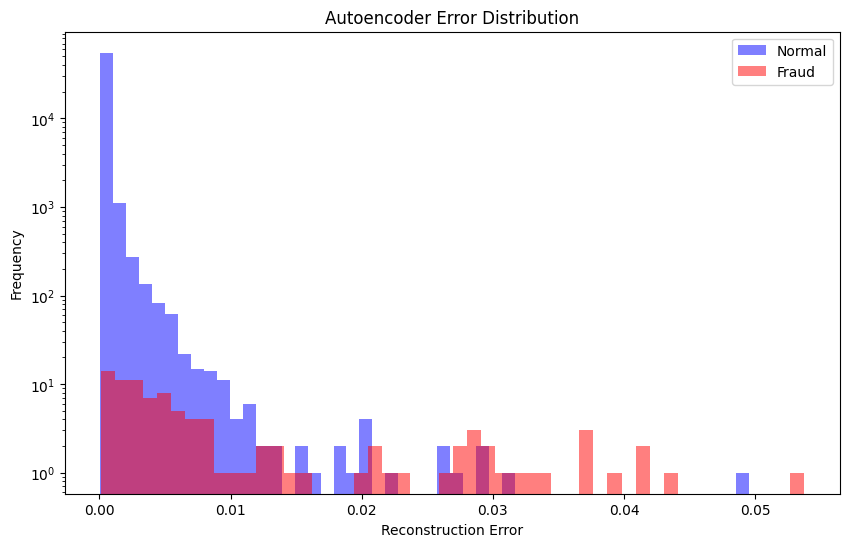

Training Variational Autoencoder
Epoch 1/50
891/891 [==============================] - 4s 3ms/step - loss: 19.8969 - val_loss: 18.7388
Epoch 2/50
891/891 [==============================] - 3s 4ms/step - loss: 18.3905 - val_loss: 18.1694
Epoch 3/50
891/891 [==============================] - 3s 3ms/step - loss: 18.1010 - val_loss: 18.0562
Epoch 4/50
891/891 [==============================] - 3s 3ms/step - loss: 18.0348 - val_loss: 18.0200
Epoch 5/50
891/891 [==============================] - 2s 3ms/step - loss: 18.0121 - val_loss: 18.0070
Epoch 6/50
891/891 [==============================] - 3s 3ms/step - loss: 18.0044 - val_loss: 18.0026
Epoch 7/50
891/891 [==============================] - 3s 4ms/step - loss: 18.0015 - val_loss: 18.0012
Epoch 8/50
891/891 [==============================] - 3s 3ms/step - loss: 18.0006 - val_loss: 18.0004
Epoch 9/50
891/891 [==============================] - 2s 3ms/step - loss: 18.0002 - val_loss: 18.0001
Epoch 10/50
891/891 [============================

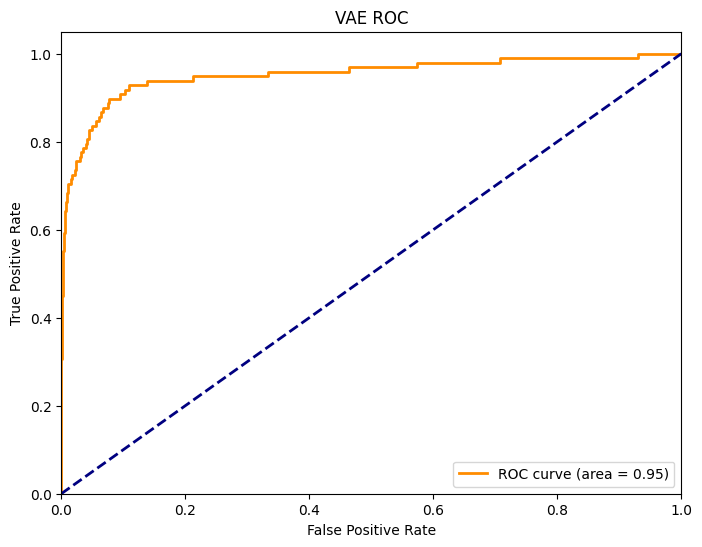

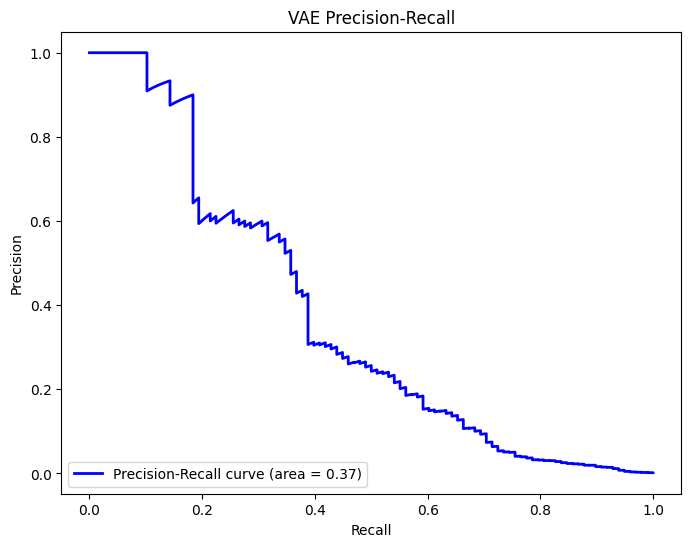

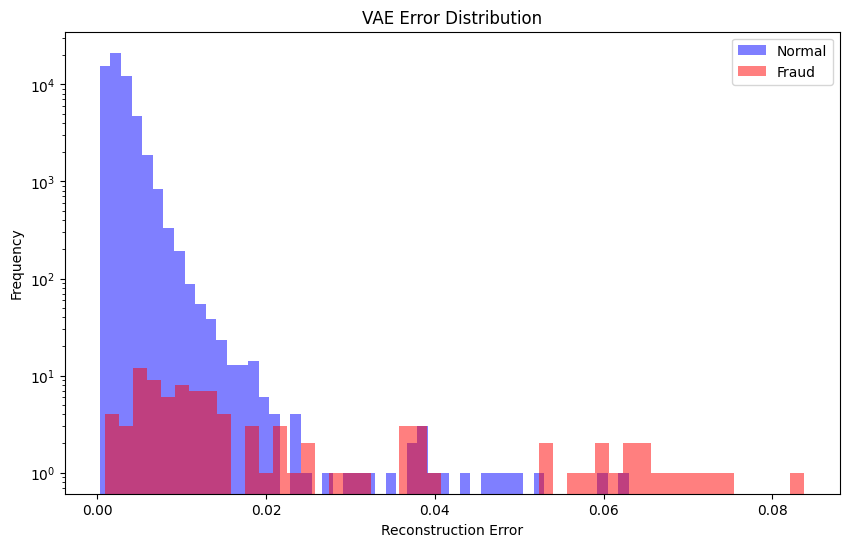

In [ ]:
def main():
    url = 'https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r'
    file_name = 'creditcard.csv'
    data = load_data(url, file_name)
    X_train, X_test, y_train, y_test = preprocess_data(data)

    # Train and evaluate Autoencoder
    print("Training Autoencoder")
    autoencoder = build_autoencoder(X_train.shape[1])
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test))

    print("Evaluating Autoencoder")
    autoencoder_mse = get_reconstruction_error(autoencoder, X_test)
    threshold = np.quantile(autoencoder_mse, 0.95)
    ae_precision, ae_recall, ae_f1 = evaluate_model(y_test, autoencoder_mse, threshold)
    print("Autoencoder Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(ae_precision, ae_recall, ae_f1))
    plot_roc_curve(y_test, autoencoder_mse, 'Autoencoder ROC')
    plot_precision_recall_curve(y_test, autoencoder_mse, 'Autoencoder Precision-Recall')
    plot_error_distribution(autoencoder_mse, y_test, 'Autoencoder Error Distribution')

    # Train and evaluate Variational Autoencoder
    print("Training Variational Autoencoder")
    vae = build_vae(X_train.shape[1])
    vae.fit(X_train, epochs=50, batch_size=256, validation_data=(X_test, None))

    print("Evaluating Variational Autoencoder")
    vae_mse = get_reconstruction_error(vae, X_test)
    threshold_vae = np.quantile(vae_mse, 0.95)
    vae_precision, vae_recall, vae_f1 = evaluate_model(y_test, vae_mse, threshold_vae)
    print("VAE Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(vae_precision, vae_recall, vae_f1))
    plot_roc_curve(y_test, vae_mse, 'VAE ROC')
    plot_precision_recall_curve(y_test, vae_mse, 'VAE Precision-Recall')
    plot_error_distribution(vae_mse, y_test, 'VAE Error Distribution')

if __name__ == "__main__":
    main()


What These Visualizations Show:
ROC Curve: Illustrates the diagnostic ability of the model as its discrimination threshold is varied. The Area Under the Curve (AUC) gives a single measure of overall performance.
Precision-Recall Curve: Especially useful in situations with a significant class imbalance, as is common in fraud detection. The area under this curve provides a measure of the model’s ability to identify only the positive instances.
Error Distribution Histogram: Shows the distribution of reconstruction errors for both normal and fraudulent transactions. A good model should show distinct peaks for normal and fraudulent transactions, indicating a clear threshold can be established for anomaly detection.
These enhancements provide a more thorough evaluation of the model's performance, helping to visualize and understand how well the models are identifying anomalies in the dataset.